## Introduction

In this lab, we will use optimization to modulate the behavior of a clustering algorithm for processing text data.  This closely mirrors work in the lecture; you should be able to copy and adapt the code there to answer lab questions.

### Data Acquision and Preprocessing

For this lab, we'll use a handful of articles from NYT and Fox News on the same evolving new story.  The goal is to see if we can characterize the differences between the two news sources. Here's code for that.

In [23]:
%pip install nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
#Uncomment the following to install nltk
#%pip install nltk
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
import pandas as pd
import re

def parse_articles(filename, source):
    """
    Parse a text file into a list of (article_id, sentence, source).
    
    - filename: path to text file
    - source: string label ("NYT" or "FOX")
    """
    rows = []
    article_id = -1
    
    with open(filename, "r", encoding="utf-8") as f:
        lines = f.readlines()
    
    buffer = []
    for line in lines:
        line = line.strip()
        
        # new article starts with a line beginning with '#'
        if line.startswith("#"):
            # flush old buffer if any
            if buffer:
                text = " ".join(buffer)
                sentences = nltk.sent_tokenize(text)
                for sent in sentences:
                    clean = re.sub(r"['\"“”‘’]", "", sent).strip()
                    if clean:  # skip empty
                        rows.append((article_id, clean, source))
                buffer = []
            
            article_id += 1  # increment article
            continue
        
        if line:  # skip blank lines
            buffer.append(line)
    
    # flush last article
    if buffer:
        text = " ".join(buffer)
        sentences = nltk.sent_tokenize(text)
        for sent in sentences:
            clean = re.sub(r"['\"“”‘’]", "", sent).strip()
            if clean:
                rows.append((article_id, clean, source))
    
    return rows

# Parse both sources
fox_rows = parse_articles("../data/fox.txt", "FOX")
nyt_rows = parse_articles("../data/nyt.txt", "NYT")

# Combine into dataframe
df = pd.DataFrame(fox_rows + nyt_rows, columns=["article_id", "sentence", "source"])

print(df.head())
print(df.shape)

   article_id                                           sentence source
0           0  Former-President Trump on Thursday denied a re...    FOX
1           0  Another fake story, that I flushed papers and ...    FOX
2           0  CNN spent much of the morning covering breakin...    FOX
3           0          Haberman is also a CNN political analyst.    FOX
4           0               We are beginning with breaking news.    FOX
(339, 3)


In [26]:
pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install hdbscan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install hyperopt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

import umap
import hdbscan

from hyperopt import fmin, tpe, rand, hp, STATUS_OK, Trials

from scipy.spatial import ConvexHull

np.random.seed(42)

### Embed the articles and visualize

Use the SentenceTransformer library with all-MiniLM-L6-v2 to derive embeddings, and then UMAP to embed the articles and look at them.  Can you distinguish between sources?  Fiddle with parameters to see how this influences your visualization.

In [30]:
pip install -U sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [31]:
def embed_texts(texts, model_name="all-MiniLM-L6-v2"):
    model = SentenceTransformer(model_name)
    return model.encode(texts, show_progress_bar=True, normalize_embeddings=True)

embeddings = embed_texts(df["sentence"].tolist())
embeddings.shape

Batches: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]


(339, 384)

### Prepare UMAP projecttions for optimization

While it is possible to use hyperparameter optimization to obtain the "best" projection you can given some loss function, it's faster to precompute a few embeddings and let the optimizer choose amongst them.  Prepare three embeddings for your optimizer.

In [ ]:
umap_configs = [
    {"n_neighbors": 5,  "min_dist": 0.05},
    {"n_neighbors": 10, "min_dist": 0.10},
    {"n_neighbors": 25, "min_dist": 0.25},
]

umap_projections = []
for cfg in umap_configs:
    reducer = umap.UMAP(
        n_neighbors=cfg["n_neighbors"],
        min_dist=cfg["min_dist"],
        n_components=2,
        random_state=42,
        metric="cosine",  # cosine often works well for sentence embeddings
    )
    umap_projections.append(reducer.fit_transform(embeddings))

[len(p) for p in umap_projections]

/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[339, 339, 339]

### Optimize for coherence and coverage

Use the code from the lab notebook to optimize for both coverage and coherence.

In [ ]:
def coverage_score(labels):
    labels = np.asarray(labels)
    return (labels != -1).mean()

def cluster_coherence_from_embeddings(embeds, labels):
    """
    Return (global_coherence, per_cluster_dict).
    global_coherence is the size-weighted mean of per-cluster mean cosine similarity.
    """
    labels = np.asarray(labels)
    mask = labels != -1
    if mask.sum() < 2 or len(np.unique(labels[mask])) < 1:
        return -1.0, {}

    per_cluster = {}
    totals = 0
    weighted_sum = 0.0

    for c in np.unique(labels[mask]):
        idx = np.where(labels == c)[0]
        if len(idx) < 2:
            per_cluster[int(c)] = -1.0
            continue
        sims = cosine_similarity(embeds[idx], embeds[idx])
        # take strict upper triangle to avoid self-similarity
        ut = np.triu_indices_from(sims, k=1)
        vals = sims[ut]
        if len(vals) == 0:
            per_cluster[int(c)] = -1.0
            continue
        coh = float(np.mean(vals))
        per_cluster[int(c)] = coh
        weighted_sum += coh * len(idx)
        totals += len(idx)

    if totals == 0:
        return -1.0, per_cluster

    global_coh = weighted_sum / totals
    # Rescale to [0,1] for visual comparability (optional, cosine sim already ~[0,1])
    return float(global_coh), per_cluster

In [34]:
def make_objective(umap_projections, embeddings, coverage_weight=0.5, min_coverage=0.5):
    # Note: coherence is computed from the original embeddings (semantic space),
    # while clustering happens in 2D (chosen UMAP projection).
    def objective(params):
        umap_ix = int(params["umap_ix"])
        min_cluster_size = int(params["min_cluster_size"])
        min_samples = int(params["min_samples"])

        coords_2d = umap_projections[umap_ix]

        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=0.0,
            metric="euclidean"  # on UMAP space
        )
        labels = clusterer.fit_predict(coords_2d)

        cov = coverage_score(labels)
        coh, _ = cluster_coherence_from_embeddings(embeddings, labels)

        if coh < 0:
            score = -1.0
        else:
            score = coverage_weight * cov + (1 - coverage_weight) * coh

        # Soft penalty for not meeting coverage target
        if cov < min_coverage:
            score -= (min_coverage - cov) * 2.0

        return {"loss": -score, "status": STATUS_OK, "labels": labels, "umap_ix": umap_ix}
    return objective


In [35]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

space = {
    "umap_ix": hp.choice("umap_ix", [0, 1, 2]),
    "min_cluster_size": hp.quniform("min_cluster_size", 3, 20, 1),
    "min_samples": hp.quniform("min_samples", 1, 10, 1),
}

coverage_weight = 0.2   # try 0.2 and 0.8 later!
min_coverage   = 0.2

objective = make_objective(umap_projections, embeddings,
                           coverage_weight=coverage_weight,
                           min_coverage=min_coverage)

trials = Trials()

# Phase 1: random
fmin(fn=objective, space=space, algo=rand.suggest,
     max_evals=10, trials=trials, verbose=True)

# Phase 2: TPE
fmin(fn=objective, space=space, algo=tpe.suggest,
     max_evals=60, trials=trials, verbose=True)

# Extract best trial
best_trial = min(trials.trials, key=lambda t: t["result"]["loss"])
best_umap_ix = best_trial["result"]["umap_ix"]
best_labels  = best_trial["result"]["labels"]
best_coords  = umap_projections[best_umap_ix]

best_cov = coverage_score(best_labels)
best_coh, per_cluster = cluster_coherence_from_embeddings(embeddings, best_labels)
best_score = coverage_weight * best_cov + (1 - coverage_weight) * best_coh

print(f"Best UMAP index: {best_umap_ix}  | config: {umap_configs[best_umap_ix]}")
print(f"Coverage: {best_cov:.3f}  | Coherence: {best_coh:.3f}  | Combined score: {best_score:.3f}")

df["cluster"] = best_labels

100%|██████████| 60/60 [00:01<00:00, 39.20trial/s, best loss: -0.545522551923143] 
Best UMAP index: 0  | config: {'n_neighbors': 5, 'min_dist': 0.05}
Coverage: 0.805  | Coherence: 0.481  | Combined score: 0.546


### Visualize your results

Have a look at your results from the optimizer, using the code from the lecture notebook.

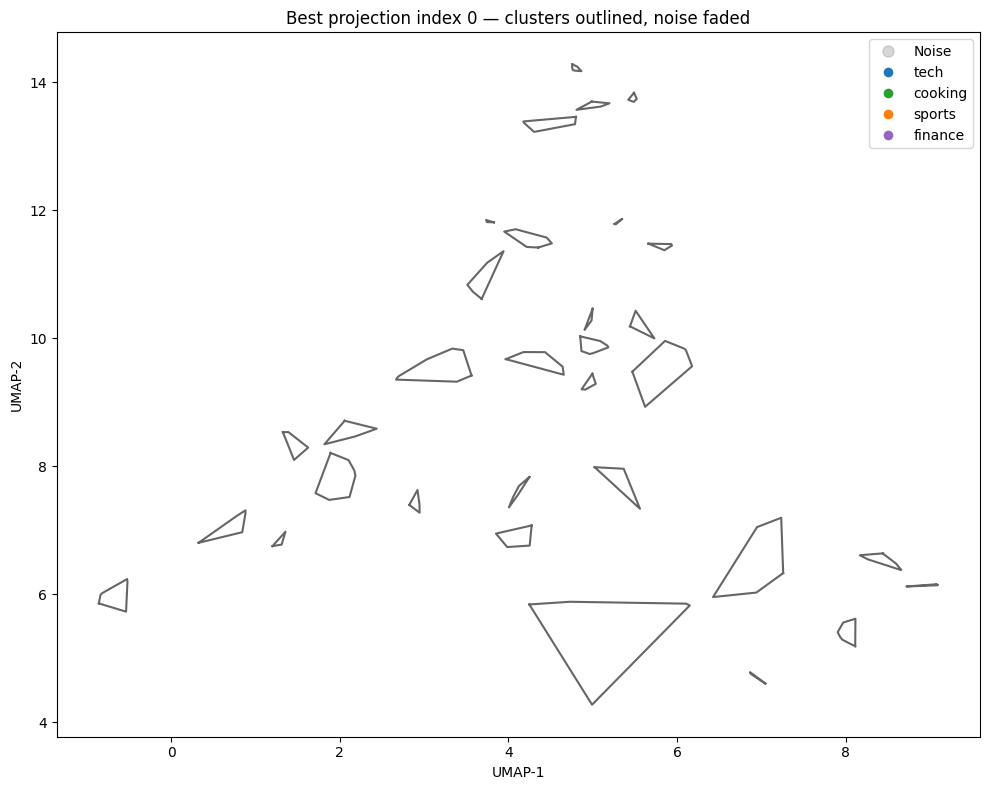

In [36]:
topic_to_color = {"tech": "#1f77b4", "cooking": "#2ca02c", "sports": "#ff7f0e", "finance": "#9467bd"}
colors = df["sentence"].map(topic_to_color).values

def plot_clusters(coords, labels, colors, draw_hulls=True, title="UMAP + HDBSCAN (semantic topics shown)"):
    plt.figure(figsize=(10, 8))
    labels = np.asarray(labels)
    unique_labels = sorted([l for l in np.unique(labels) if l != -1])

    # Noise first (low alpha)
    noise_mask = labels == -1
    plt.scatter(coords[noise_mask, 0], coords[noise_mask, 1],
                c=colors[noise_mask], alpha=0.25, s=30, label="Noise")

    # Clusters (higher alpha)
    for c in unique_labels:
        mask = labels == c
        plt.scatter(coords[mask, 0], coords[mask, 1],
                    c=colors[mask], alpha=0.9, s=35, label=f"Cluster {c}")

        # Optional convex hull outline
        if draw_hulls and mask.sum() >= 3:
            try:
                hull = ConvexHull(coords[mask])
                hull_pts = coords[mask][hull.vertices]
                plt.plot(np.append(hull_pts[:,0], hull_pts[0,0]),
                         np.append(hull_pts[:,1], hull_pts[0,1]),
                         linestyle='-', linewidth=1.5, color='black', alpha=0.6)
            except Exception:
                pass

    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    # Custom legend: topic colors + noise entry
    from matplotlib.lines import Line2D
    legend_items = [Line2D([0],[0], marker='o', color='w', label=t,
                           markerfacecolor=topic_to_color[t], markersize=8)
                    for t in topic_to_color]
    legend_items.insert(0, Line2D([0],[0], marker='o', color='w', label='Noise',
                                  markerfacecolor='gray', markeredgecolor='gray', alpha=0.3, markersize=8))
    plt.legend(handles=legend_items, loc="best", frameon=True)
    plt.tight_layout()
    plt.show()

plot_clusters(best_coords, best_labels, colors, draw_hulls=True,
              title=f"Best projection index {best_umap_ix} — clusters outlined, noise faded")

### Inspect your data

Build a function to list out a sample the sentences for a given cluster, and then build another function to iterate over these clusters in order, printing out the sentences for each.

In [40]:
import pandas as pd

def sample_cluster_sentences(df, article_id, n=5, random_state=42):
    """
    Return a sample of sentences for a given cluster.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must include columns ['sentence', 'source', 'cluster'].
    cluster_id : int
        The cluster label to sample.
    n : int
        Number of example sentences to return.
    random_state : int
        Random seed for reproducibility.
    
    Returns
    -------
    pd.DataFrame
        A small dataframe of sample sentences and their sources.
    """
    cluster_df = df[df["cluster"] == article_id]
    if cluster_df.empty:
        print(f"⚠️  Cluster {article_id} is empty or not found.")
        return pd.DataFrame(columns=["sentence", "source", "cluster"])

    sample_df = cluster_df.sample(n=min(n, len(cluster_df)), random_state=random_state)
    return sample_df[["article_id", "sentence", "source", "cluster"]]


In [41]:
def print_cluster_samples(df, n=5):
    """
    Iterate through all clusters in order, printing example sentences.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must include columns ['sentence', 'source', 'cluster'].
    n : int
        Number of example sentences per cluster.
    """
    clusters = sorted(df["cluster"].unique())
    for c in clusters:
        if c == -1:
            print("\n=== 🌀 Noise / Unclustered Sentences ===")
        else:
            print(f"\n=== Cluster {c} ===")

        sample_df = sample_cluster_sentences(df, c, n=n)
        for _, row in sample_df.iterrows():
            print(f"({row['source']}) {row['sentence']}")


In [42]:
# Suppose df looks like:
# sentence | source | cluster
# ---------------------------
# "The market rallied..." | "FOX" | 0
# "Stocks hit record highs..." | "NYT" | 0
# "The team won the championship..." | "FOX" | 1
# ...

print_cluster_samples(df, n=3)



=== 🌀 Noise / Unclustered Sentences ===
(NYT) He was watching television as the riot played out on cable news, and several aides, including his daughter Ivanka Trump, implored him to say something to try to get the rioters to stop.
(NYT) It also provides a process for destroying records that typically includes seeking permission from the archivist of the United States, who may consult with Congress.
(FOX) The Democrats are just using this and the Unselect Committee of political hacks as a camouflage for how horribly our Country is doing under the Biden Administration, Trump said.

=== Cluster 0 ===
(FOX) He is backing the RNCs censure of Liz Cheney and Adam Kinzinger for helping probe legitimate political discourse on Jan. 6.
(NYT) Nevertheless, his first public communication as the melee unfolded was a Twitter post attacking Vice President Mike Pence, who was presiding over the joint session of Congress to count the Electoral College votes.
(FOX) He is in a war of words with Mitch Mc

### Identify patterns

Build another visualization function that allows you to inspect the relative number of articles from either source.

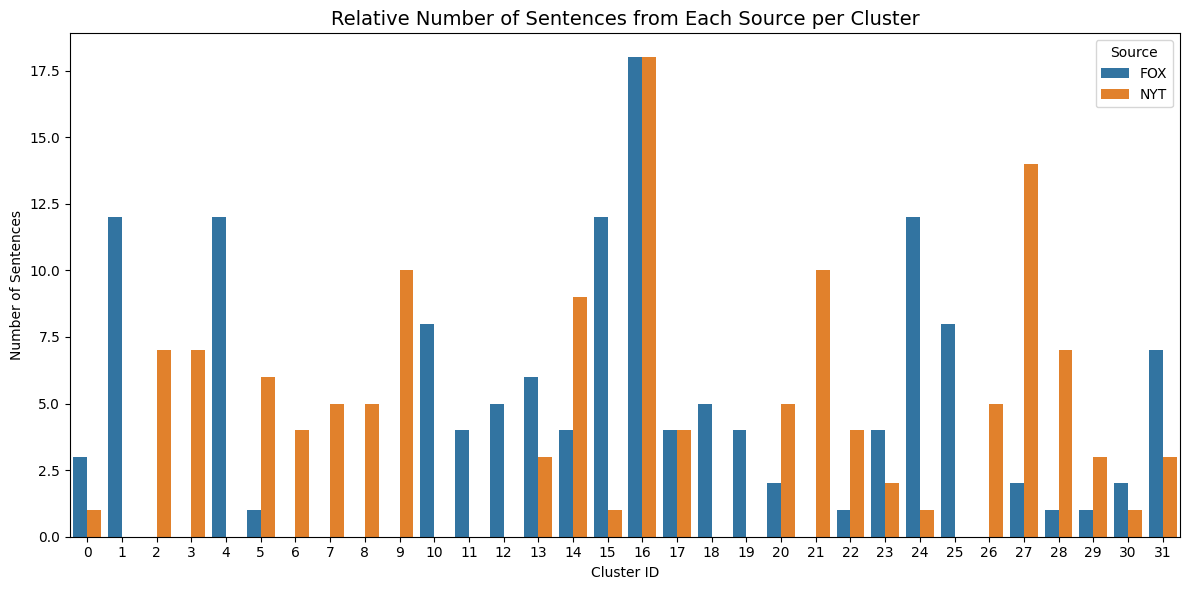

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_source_balance(df):
    """
    Show how many sentences (or articles) from each source
    appear in each cluster, to help identify source-specific patterns.
    """

    # Exclude noise clusters (-1) for clarity
    data = df[df["cluster"] != -1]

    # Count sentences per (cluster, source)
    counts = (
        data.groupby(["cluster", "source"])
        .size()
        .reset_index(name="count")
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=counts,
        x="cluster",
        y="count",
        hue="source",
        palette=["#1f77b4", "#ff7f0e"]  # NYT blue, FOX orange
    )
    plt.title("Relative Number of Sentences from Each Source per Cluster", fontsize=14)
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Sentences")
    plt.legend(title="Source")
    plt.tight_layout()
    plt.show()
df["cluster"] = best_labels
visualize_source_balance(df)


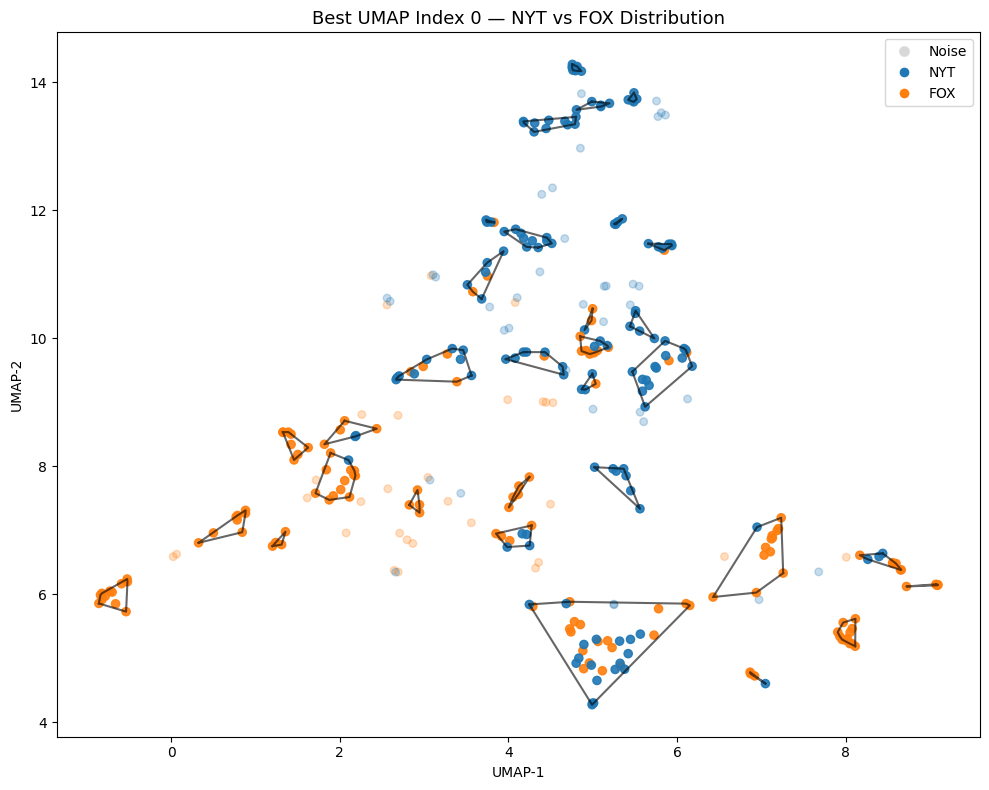

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from matplotlib.lines import Line2D

# Color map for your two news sources
source_to_color = {"NYT": "#1f77b4", "FOX": "#ff7f0e"}

def plot_source_clusters(coords, labels, sources, draw_hulls=True,
                         title="UMAP + HDBSCAN — Sources Highlighted"):
    """
    Visualize 2-D UMAP + HDBSCAN clusters, color-coded by news source.

    Parameters
    ----------
    coords : np.ndarray
        2-D coordinates from UMAP (N × 2)
    labels : array-like
        Cluster labels from HDBSCAN
    sources : array-like
        Source strings (e.g., 'NYT' or 'FOX')
    draw_hulls : bool
        Whether to outline clusters with convex hulls
    title : str
        Plot title
    """
    plt.figure(figsize=(10, 8))
    labels = np.asarray(labels)
    unique_labels = sorted([l for l in np.unique(labels) if l != -1])

    # Map colors to each sentence by its source
    colors = [source_to_color.get(src, "gray") for src in sources]

    # Plot noise first (faded)
    noise_mask = labels == -1
    plt.scatter(coords[noise_mask, 0], coords[noise_mask, 1],
                c=np.array(colors)[noise_mask],
                alpha=0.25, s=30, label="Noise")

    # Plot each cluster
    for c in unique_labels:
        mask = labels == c
        plt.scatter(coords[mask, 0], coords[mask, 1],
                    c=np.array(colors)[mask],
                    alpha=0.9, s=35, label=f"Cluster {c}")

        # Optional convex-hull outline
        if draw_hulls and mask.sum() >= 3:
            try:
                hull = ConvexHull(coords[mask])
                hull_pts = coords[mask][hull.vertices]
                plt.plot(np.append(hull_pts[:, 0], hull_pts[0, 0]),
                         np.append(hull_pts[:, 1], hull_pts[0, 1]),
                         linestyle='-', linewidth=1.5, color='black', alpha=0.6)
            except Exception:
                pass

    plt.title(title, fontsize=13)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")

    # Custom legend showing FOX vs NYT
    legend_items = [
        Line2D([0], [0], marker='o', color='w', label=src,
               markerfacecolor=clr, markersize=8)
        for src, clr in source_to_color.items()
    ]
    legend_items.insert(0, Line2D([0], [0], marker='o', color='w',
                                  label='Noise',
                                  markerfacecolor='gray', alpha=0.3, markersize=8))
    plt.legend(handles=legend_items, loc="best", frameon=True)
    plt.tight_layout()
    plt.show()
    
plot_source_clusters(
    best_coords,          # your 2-D UMAP projection
    best_labels,          # cluster labels from HDBSCAN
    df["source"].values,  # news sources
    draw_hulls=True,
    title=f"Best UMAP Index {best_umap_ix} — NYT vs FOX Distribution"
)


### Play with parameters!  Adjust your toolkit!

Now that you've built yourself a small analytical toolkit, you can go back and adjust the code to inspect different parameter sets, or enhance its functionality. Try:

- Shifting the balance between coherence and coverage
- Changing the importance of cluster size
- Labeling the clusters in the scatter plot
- Algorithmically detecting the key differentiating topics.

What makes sense?  What can you learn?  What might come next?